<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/MCSO/notebooks/09_ComparandoMLP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparativa entre MLP y CNN para predicción de imágeens
## Usaremos el SVHN dataset

Crearemos a neural network that classifies real-world images digits. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

![SVHN overview image](https://github.com/manishkadam007/Getting-started-with-Tensorflow-2/blob/master/week%205/data/svhn_examples.jpg?raw=1)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# with large files it is best to access them via drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run this cell to load the dataset in my drive folder

train = loadmat('/content/drive/MyDrive/Colab Notebooks/MCSO/data/train_32x32.mat')
test = loadmat('/content/drive/MyDrive/Colab Notebooks/MCSO/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']

In [ ]:
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

In [ ]:
y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

We compare the labels with the images.

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


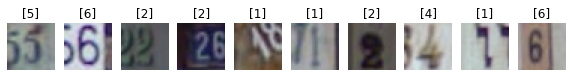

In [ ]:
indices = random.sample( range(0,X_train.shape[0]), 10 )
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[indices[i]])
    ax[i].set_title(y_train[indices[i]])

In [ ]:
X_train_greyscale = np.mean(X_train, -1, keepdims=True)
X_test_greyscale = np.mean(X_test, -1, keepdims=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


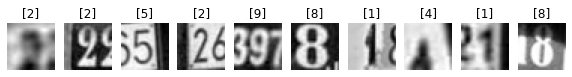

In [ ]:
indices = random.sample( range(0,X_train_greyscale.shape[0]), 10 )
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train_greyscale[indices[i],:,:,0], cmap='gray')
    ax[i].set_title(y_train[indices[i]])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
def get_new_MLP_model():
    
    Model = Sequential([
        Flatten(input_shape=X_train[0].shape),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    return Model

model = get_new_MLP_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 2,001,546
Trainable params: 2,001,546
Non-trainable params: 0
______________________________________________

ModelCheckpoint callback

In [ ]:
cp_path = 'Checkpoint/Best_model'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

patience is a very interesting parameter as we can adjust it to get better predictions.

In [ ]:
EarlyStop = EarlyStopping(monitor='loss', mode='min', patience=5)

I also tried with patience=3 but it stopped too much before epoch 30, that's why I tried to hold until 5.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1, validation_split=0.1, callbacks=[cp, EarlyStop])

Epoch 1/30
1031/1031 [==============================] - 25s 24ms/step - loss: 41.8414 - accuracy: 0.1540 - val_loss: 2.0357 - val_accuracy: 0.3642
Epoch 2/30
1031/1031 [==============================] - 24s 23ms/step - loss: 1.6434 - accuracy: 0.4628 - val_loss: 1.4817 - val_accuracy: 0.5102
Epoch 3/30
1031/1031 [==============================] - 24s 23ms/step - loss: 1.3633 - accuracy: 0.5688 - val_loss: 1.3577 - val_accuracy: 0.5618
Epoch 4/30
1031/1031 [==============================] - 24s 23ms/step - loss: 1.2507 - accuracy: 0.6087 - val_loss: 1.1230 - val_accuracy: 0.6508
Epoch 5/30
1031/1031 [==============================] - 24s 23ms/step - loss: 1.1674 - accuracy: 0.6367 - val_loss: 1.1770 - val_accuracy: 0.6198
Epoch 6/30
1031/1031 [==============================] - 24s 23ms/step - loss: 1.1351 - accuracy: 0.6473 - val_loss: 1.1426 - val_accuracy: 0.6421
Epoch 7/30
1031/1031 [==============================] - 24s 23ms/step - loss: 1.0665 - accuracy: 0.6715 - val_loss: 1.0876 

On this occasion, it can be observed that by increasing the patience parameter to 5, no earlystop has occurred until reaching epoch number 30.

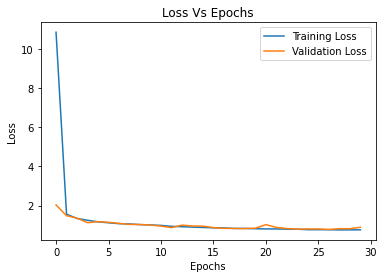

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

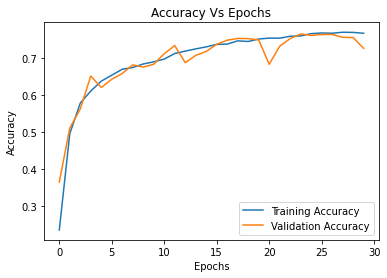

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

The graphs are very illustrative, showing on the one hand how loss is decreasing and on the other hand how accuracy is improving by

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Test Loss is {test_loss}")
print(f"Test Accuracy is {test_accuracy}")

Test Loss is 1.0395140647888184
Test Accuracy is 0.6981791853904724


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
def get_new_CNN_model():
    
    Model = Sequential([
        Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train[0].shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(16, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(16, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    
    return Model

CNN_model = get_new_CNN_model()
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)         

In [ ]:
cp_path = 'CNN_Checkpoint/Best_model'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [ ]:
EarlyStop = EarlyStopping(monitor='loss', mode='min', patience=5)

In [ ]:
CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_CNN = CNN_model.fit(X_train, y_train, epochs=30, batch_size=64,
                        verbose=1, validation_split=0.1, callbacks=[cp, EarlyStop])

Epoch 1/30
1031/1031 [==============================] - 76s 73ms/step - loss: 1.6238 - accuracy: 0.4382 - val_loss: 0.5526 - val_accuracy: 0.8251
Epoch 2/30
1031/1031 [==============================] - 74s 72ms/step - loss: 0.5456 - accuracy: 0.8301 - val_loss: 0.4736 - val_accuracy: 0.8531
Epoch 3/30
1031/1031 [==============================] - 73s 71ms/step - loss: 0.4434 - accuracy: 0.8639 - val_loss: 0.3976 - val_accuracy: 0.8774
Epoch 4/30
1031/1031 [==============================] - 74s 71ms/step - loss: 0.3789 - accuracy: 0.8816 - val_loss: 0.3882 - val_accuracy: 0.8812
Epoch 5/30
1031/1031 [==============================] - 74s 71ms/step - loss: 0.3400 - accuracy: 0.8953 - val_loss: 0.3526 - val_accuracy: 0.8948
Epoch 6/30
1031/1031 [==============================] - 74s 72ms/step - loss: 0.3076 - accuracy: 0.9058 - val_loss: 0.3596 - val_accuracy: 0.8924
Epoch 7/30
1031/1031 [==============================] - 74s 72ms/step - loss: 0.2869 - accuracy: 0.9115 - val_loss: 0.3895 -

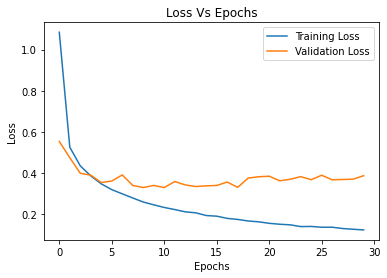

In [ ]:
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title("Loss Vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

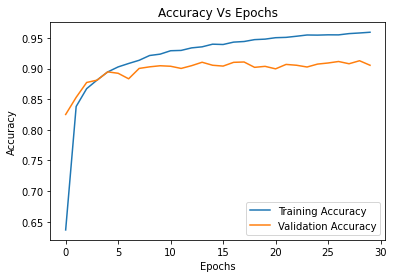

In [ ]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title("Accuracy Vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = CNN_model.evaluate(X_test, y_test, verbose=False)
print(f"Test Loss is {test_loss}")
print(f"Test Accuracy is {test_accuracy}")

Test Loss is 0.46470633149147034
Test Accuracy is 0.8978949189186096


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

we look for the best predictions with the checkpoint of each of the two models. 

In [ ]:
Best_MLP = get_new_MLP_model()
Best_MLP.load_weights('Checkpoint/Best_model')

In [ ]:
Best_CNN = get_new_CNN_model()
Best_CNN.load_weights('CNN_Checkpoint/Best_model')

Finally, we constructed a graphical form to represent the prediction of the two models MLP and CNN and to see their prediction efficiency.

In [ ]:
def show_predictive_distribution(model):

    num_test_images = X_test.shape[0]

    random_inx = np.random.choice(num_test_images, 5)
    random_test_images = X_test[random_inx, ...]
    random_test_labels = y_test[random_inx, ...]

    predictions = model.predict(random_test_images)

    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        axes[i, 1].bar(np.arange(len(prediction)), prediction)
        axes[i, 1].set_xticks(np.arange(len(prediction)))
        axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
    plt.show()

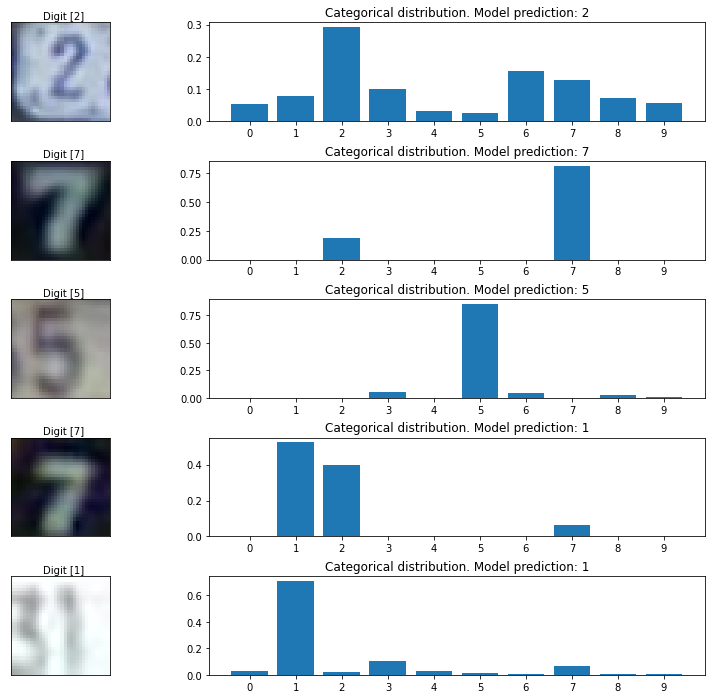

In [ ]:
show_predictive_distribution(Best_MLP)

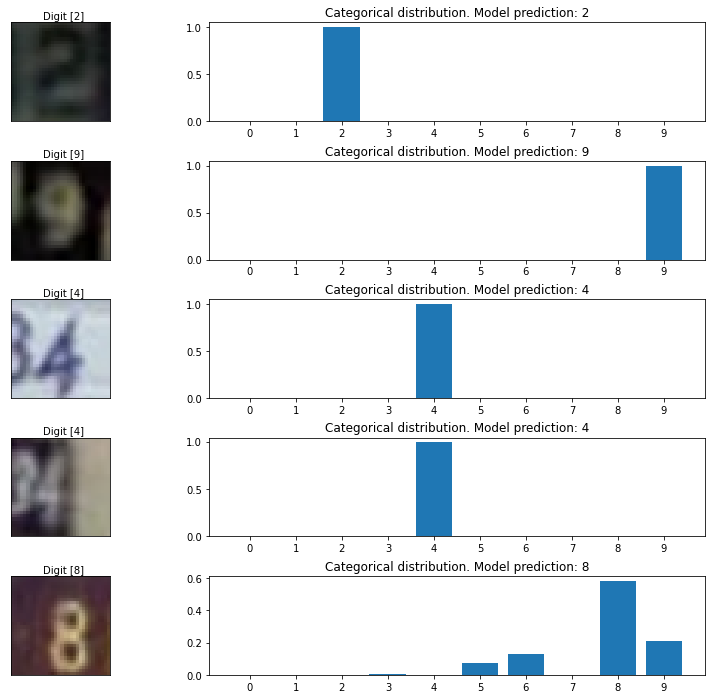

In [ ]:
show_predictive_distribution(Best_CNN)